<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
cd /content/drive/MyDrive/ML_TeamProject/

/content/drive/MyDrive/ML_TeamProject


In [4]:
image_gray_jpg_path = "/content/drive/My Drive/ML_TeamProject/images_gray_jpg"

In [5]:
image_path = image_gray_jpg_path

In [6]:
os.chdir(os.path.join(image_path, 'overripe'))
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir(os.path.join(image_path, 'no'))
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))

os.chdir(os.path.join(image_path, 'mature'))
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))

os.chdir(os.path.join(image_path, 'incipient'))
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

overripe :  2000
no :  2000
mature :  2000
incipient :  2000


Dictionary to numpy array

In [7]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

overripe_data shape: (2000, 224, 224, 3)
no_data shape: (2000, 224, 224, 3)
mature_data shape: (2000, 224, 224, 3)
incipient_data shape: (2000, 224, 224, 3)


In [8]:
from tensorflow.keras.utils import to_categorical
# 데이터를 train/validation/test로 나누기
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


In [9]:
del overripe, no, mature, incipient
# del overripe_data, no_data, mature_data, incipient_data
del overripe_data_list, no_data_list, mature_data_list, incipient_data_list
del X, y
del y_train, y_temp, y_val, y_test

In [10]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00


In [11]:
import optuna
from optuna.visualization import plot_optimization_history

In [ ]:

def objective(trial, X_train, y_train, X_val, y_val):
    # Define parameters to be tuned
    # 여기서 lr, epochs, batch_size가 하이퍼파라미터튜닝 대상입니다.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate
    epochs = 10
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size

    # ResNet50 모델 생성
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 미세 조정 (Fine-tuning) 설정
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    return val_loss

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train_one_hot, X_val, y_val_one_hot), n_trials=5)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-05-13 16:04:38,857] A new study created in memory with name: no-name-c12e7570-6efc-45b3-99f2-60f3b84c14bf
<ipython-input-16-7d5ffbb05915>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate


94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/10
350/350 [==============================] - 20s 38ms/step - loss: 1.3633 - accuracy: 0.3209 - val_loss: 1.3488 - val_accuracy: 0.3567
Epoch 2/10
350/350 [==============================] - 11s 31ms/step - loss: 1.2842 - accuracy: 0.3941 - val_loss: 1.2666 - val_accuracy: 0.3767
Epoch 3/10
350/350 [==============================] - 11s 31ms/step - loss: 1.2544 - accuracy: 0.4032 - val_loss: 1.2270 - val_accuracy: 0.4183
Epoch 4/10
350/350 [==============================] - 11s 32ms/step - loss: 1.2290 - accuracy: 0.4136 - val_loss: 1.2255 - val_accuracy: 0.4133
Epoch 5/10
350/350 [==============================] - 11s 31ms/step - loss: 1.2022 - accuracy: 0.4305 - val_loss: 1.1834 - val_accuracy: 0.4350
Epoch 6/10
350/350 [==============================] - 11s 31ms/step - loss: 1.1936 - accuracy: 0.4400 - val_loss: 1.1940 - val_accuracy: 0.4250
Epoch 7/10
350/350 [==============================] - 11s 31ms/step - loss: 1.1703 - accuracy: 0.4598 - val_loss: 1.1800 - val_accuracy:

[I 2024-05-13 16:06:46,362] Trial 0 finished with value: 1.197036862373352 and parameters: {'lr': 0.0008840210975508395, 'batch_size': 16}. Best is trial 0 with value: 1.197036862373352.


Epoch 1/10
88/88 [==============================] - 21s 181ms/step - loss: 1.3914 - accuracy: 0.2925 - val_loss: 1.3564 - val_accuracy: 0.2592
Epoch 2/10
88/88 [==============================] - 11s 129ms/step - loss: 1.3367 - accuracy: 0.3529 - val_loss: 1.3115 - val_accuracy: 0.3625
Epoch 3/10
88/88 [==============================] - 11s 129ms/step - loss: 1.3044 - accuracy: 0.3809 - val_loss: 1.2872 - val_accuracy: 0.3900
Epoch 4/10
88/88 [==============================] - 11s 129ms/step - loss: 1.2854 - accuracy: 0.3916 - val_loss: 1.2917 - val_accuracy: 0.3900
Epoch 5/10
88/88 [==============================] - 11s 128ms/step - loss: 1.2624 - accuracy: 0.4000 - val_loss: 1.2606 - val_accuracy: 0.4083
Epoch 6/10
88/88 [==============================] - 11s 128ms/step - loss: 1.2478 - accuracy: 0.4168 - val_loss: 1.2351 - val_accuracy: 0.3908
Epoch 7/10
88/88 [==============================] - 11s 128ms/step - loss: 1.2393 - accuracy: 0.4161 - val_loss: 1.2290 - val_accuracy: 0.4208

[I 2024-05-13 16:08:56,287] Trial 1 finished with value: 1.190119981765747 and parameters: {'lr': 0.0003375583691971872, 'batch_size': 64}. Best is trial 1 with value: 1.190119981765747.


Epoch 1/10
175/175 [==============================] - 16s 74ms/step - loss: 1.3745 - accuracy: 0.3334 - val_loss: 1.3192 - val_accuracy: 0.3842
Epoch 2/10
175/175 [==============================] - 11s 63ms/step - loss: 1.3123 - accuracy: 0.3657 - val_loss: 1.2793 - val_accuracy: 0.4117
Epoch 3/10
175/175 [==============================] - 11s 62ms/step - loss: 1.2750 - accuracy: 0.4011 - val_loss: 1.2545 - val_accuracy: 0.4017
Epoch 4/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2529 - accuracy: 0.4093 - val_loss: 1.2382 - val_accuracy: 0.3883
Epoch 5/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2340 - accuracy: 0.4211 - val_loss: 1.2314 - val_accuracy: 0.3917
Epoch 6/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2161 - accuracy: 0.4275 - val_loss: 1.2224 - val_accuracy: 0.4092
Epoch 7/10
175/175 [==============================] - 11s 62ms/step - loss: 1.2058 - accuracy: 0.4384 - val_loss: 1.1835 - val_accuracy:

[I 2024-05-13 16:10:57,616] Trial 2 finished with value: 1.1677687168121338 and parameters: {'lr': 0.0007831265660152335, 'batch_size': 32}. Best is trial 2 with value: 1.1677687168121338.


Epoch 1/10
175/175 [==============================] - 16s 73ms/step - loss: 1.3582 - accuracy: 0.3177 - val_loss: 1.3168 - val_accuracy: 0.3817
Epoch 2/10
175/175 [==============================] - 11s 63ms/step - loss: 1.3018 - accuracy: 0.3850 - val_loss: 1.2928 - val_accuracy: 0.3583
Epoch 3/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2655 - accuracy: 0.4080 - val_loss: 1.3059 - val_accuracy: 0.3042
Epoch 4/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2455 - accuracy: 0.4204 - val_loss: 1.2250 - val_accuracy: 0.4258
Epoch 5/10
175/175 [==============================] - 11s 62ms/step - loss: 1.2261 - accuracy: 0.4161 - val_loss: 1.2245 - val_accuracy: 0.4025
Epoch 6/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2133 - accuracy: 0.4355 - val_loss: 1.1957 - val_accuracy: 0.4308
Epoch 7/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2007 - accuracy: 0.4398 - val_loss: 1.2842 - val_accuracy:

[I 2024-05-13 16:12:58,873] Trial 3 finished with value: 1.1470320224761963 and parameters: {'lr': 0.00011505750532476763, 'batch_size': 32}. Best is trial 3 with value: 1.1470320224761963.


Epoch 1/10
175/175 [==============================] - 16s 74ms/step - loss: 1.3576 - accuracy: 0.3261 - val_loss: 1.3143 - val_accuracy: 0.3908
Epoch 2/10
175/175 [==============================] - 11s 63ms/step - loss: 1.3011 - accuracy: 0.3804 - val_loss: 1.2842 - val_accuracy: 0.3867
Epoch 3/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2710 - accuracy: 0.3945 - val_loss: 1.2410 - val_accuracy: 0.4225
Epoch 4/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2430 - accuracy: 0.4182 - val_loss: 1.2245 - val_accuracy: 0.3942
Epoch 5/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2335 - accuracy: 0.4187 - val_loss: 1.2277 - val_accuracy: 0.4025
Epoch 6/10
175/175 [==============================] - 11s 63ms/step - loss: 1.2146 - accuracy: 0.4291 - val_loss: 1.2099 - val_accuracy: 0.4300
Epoch 7/10
175/175 [==============================] - 11s 63ms/step - loss: 1.1990 - accuracy: 0.4380 - val_loss: 1.1841 - val_accuracy:

[I 2024-05-13 16:15:01,348] Trial 4 finished with value: 1.1886732578277588 and parameters: {'lr': 6.938559181409881e-05, 'batch_size': 32}. Best is trial 3 with value: 1.1470320224761963.


Best parameters: {'lr': 0.00011505750532476763, 'batch_size': 32}


## ResNet50 학습

In [12]:
labels = ['overripe', 'no','mature', 'incipient']

Epoch 1/50
175/175 [==============================] - 30s 132ms/step - loss: 1.3729 - accuracy: 0.3146 - val_loss: 1.3208 - val_accuracy: 0.3800
Epoch 2/50
175/175 [==============================] - 20s 114ms/step - loss: 1.3093 - accuracy: 0.3836 - val_loss: 1.2868 - val_accuracy: 0.3625
Epoch 3/50
175/175 [==============================] - 20s 115ms/step - loss: 1.2794 - accuracy: 0.3855 - val_loss: 1.2791 - val_accuracy: 0.4150
Epoch 4/50
175/175 [==============================] - 20s 113ms/step - loss: 1.2555 - accuracy: 0.4077 - val_loss: 1.2350 - val_accuracy: 0.4308
Epoch 5/50
175/175 [==============================] - 19s 111ms/step - loss: 1.2356 - accuracy: 0.4180 - val_loss: 1.2613 - val_accuracy: 0.3883
Epoch 6/50
175/175 [==============================] - 20s 113ms/step - loss: 1.2159 - accuracy: 0.4302 - val_loss: 1.2075 - val_accuracy: 0.4258
Epoch 7/50
175/175 [==============================] - 20s 112ms/step - loss: 1.2014 - accuracy: 0.4355 - val_loss: 1.2154 - val_ac

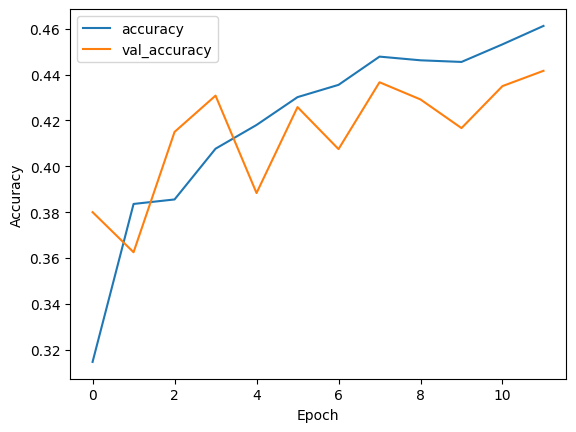

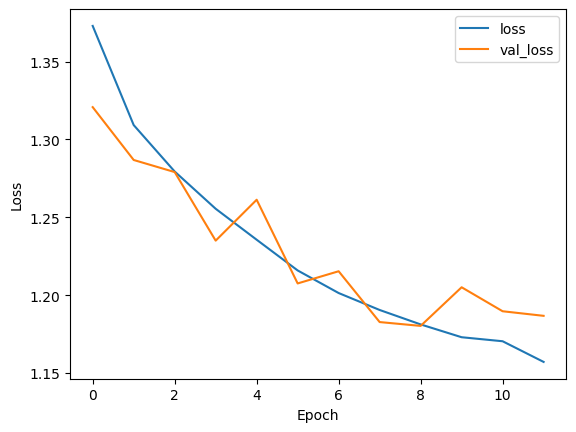

38/38 [==============================] - 4s 92ms/step - loss: 1.1868 - accuracy: 0.4350
Test accuracy: 0.4350000023841858


In [13]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# ResNet50 모델 생성
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 미세 조정 (Fine-tuning) 설정
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train,
    y_train_one_hot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[early_stopping]
)

# 시각화를 통한 정확도 및 손실도 확인
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)


In [15]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=dd8caed837b25462dc0c9c0dffcae55051ccda1c99bf3ae8f928fd100a05438d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [15]:
from PIL import Image
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image

def visualize_image(image_data):
  # LIME 설명 인스턴스 생성
  explainer = lime_image.LimeImageExplainer()

  # LIME이 필요한 이미지 하나 불러오기
  # image = incipient_data[0]
  image_15 = image_data[:15]

  fig, axes = plt.subplots(3, 5, figsize=(15, 9))

  for i, ax in enumerate(axes.flatten()):
    image = image_15[i]

    # LIME 설명 생성
    explanation = explainer.explain_instance(image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

    # 설명된 이미지와 설명에 대한 마스크 가져오기
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

    # 설명된 이미지와 마스크를 원본 이미지에 적용
    marked_image = mark_boundaries(temp / 2 + 0.5, mask)

    ax.imshow(marked_image)
    ax.set_title(labels[explanation.top_labels[0]])
    ax.axis('off')

  plt.tight_layout()
  plt.show()
    # # 이미지 출력
    # plt.imshow(marked_image)
    # plt.axis('off')
    # plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


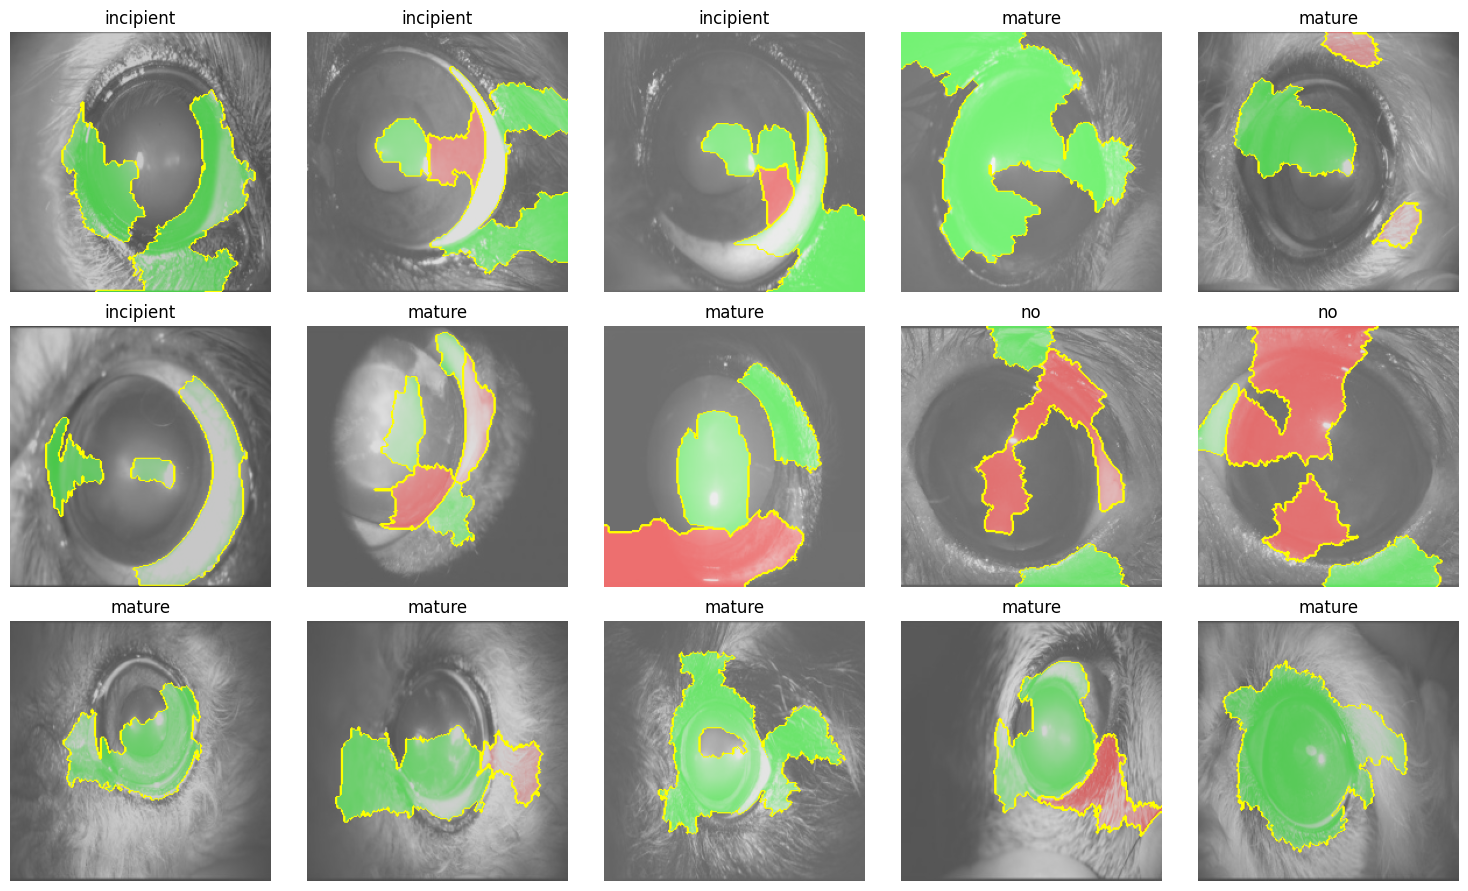

In [18]:
visualize_image(incipient_data)